In [ ]:
!pip install indic-nlp-library

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt

import torch
from torch import nn,tensor
from torch.utils.data import Dataset,DataLoader
from torchtext.vocab import build_vocab_from_iterator
from tqdm import tqdm
import re
import numpy as np
import pandas as pd
import pickle
from indicnlp.tokenize import indic_tokenize
import seaborn as sns

train_path = '/content/drive/MyDrive/Colab Notebooks/INLP Project/product_reviews/hi/hi-train.csv'
test_path ='/content/drive/MyDrive/Colab Notebooks/INLP Project/product_reviews/hi/hi-test.csv'
val_path = '/content/drive/MyDrive/Colab Notebooks/INLP Project/product_reviews/hi/hi-valid.csv'
forward_model_path ='/content/drive/MyDrive/Colab Notebooks/INLP Project/train embeddings/pretrained_forward_model'
backward_model_path ='/content/drive/MyDrive/Colab Notebooks/INLP Project/train embeddings/pretrained_backward_model'
word_to_ix_path = '/content/drive/MyDrive/Colab Notebooks/INLP Project/train embeddings/word_to_ix.pkl'

In [ ]:

train_df = pd.read_csv(train_path, header=None, names=['Label', 'Text'])

test_df = pd.read_csv(test_path, header=None, names=['Label', 'Text'])
train_df.head()



,Label,Text
0,negative,एंडराॅयड के मामले में यह थोड़ा पीछे है ।
1,neutral,यह एस्पेक्ट रेशो का ईश्यू है और हम आशा करते है...
2,positive,लेकिन इस तरह के एक मॉडल के एक घर कंप्यूटर के ल...
3,positive,गिर वन राष्ट्रीय उद्यान बाघ संरक्षित क्षेत्र ह...
4,neutral,"और हां , इस फिल्म में हर किरदार भारद्वाज को भर..."


In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_df['Label'] = label_encoder.fit_transform(train_df['Label'])
test_df['Label'] = label_encoder.transform(test_df['Label'])
test_df.head()


,Label,Text
0,1,"मगर , इस तरफ कोई ध्यान नहीं दिया जा रहा ।"
1,0,गेम कई बार मुश्किल मालूम देता है ।
2,0,मल्टीप्लेयर में छोटी स्टोरीलाइन है ।
3,2,हाई - एंड एचपी नोटबुक्स की लुक्स हमेशा बेहतरीन...
4,2,कैमरे बनाने वाली कंपनी निकोन अपनी 1 सीरीज कैमर...


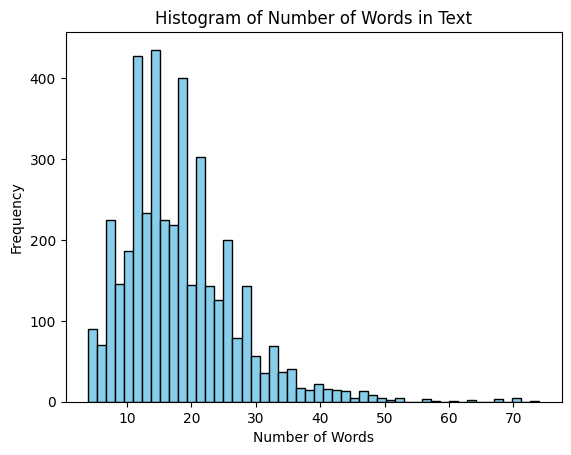

In [ ]:

text_word_counts = train_df['Text'].apply(lambda x: len(x.split()))

plt.hist(text_word_counts, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Words in Text')
plt.show()


In [ ]:
class ElmoProcessor(torch.nn.Module):
    def __init__(self,vocab_size,embedding_dim,hidden_dim,wt_mat):
        super(ElmoProcessor,self).__init__()
        #self.embeddings=nn.Embedding(vocab_size,embedding_dim)
        self.lstmf1=nn.LSTM(embedding_dim,hidden_dim,num_layers=1,bidirectional=False,batch_first=True)
        self.lstmf2=nn.LSTM(hidden_dim,hidden_size=hidden_dim,bidirectional=False,batch_first=True)
        self.embedding=wt_mat.to(device)
        # self.lstmb1=nn.LSTM(embedding_dim,hidden_dim,num_layers=1,bidirectional=False,batch_first=True)
        # self.lstmb2=nn.LSTM(hidden_dim,hidden_size=hidden_dim,bidirectional=False,batch_first=True)

        self.linear=nn.Linear(hidden_dim,vocab_size)
    def forward(self,embeddingdata):
        emb=torch.tensor(self.embedding(embeddingdata.to(device)))

        emb_f=emb
        # emb_b=emb.flip(1)

        o1f1,h1f1=self.lstmf1(emb_f)
        o2f2,h2f2=self.lstmf2(o1f1)
        # o2f2=o2f2+o1f1
        # h2f2=h2f2+h1f1
        # o1b1,h1b1=self.lstmb1(emb_b)
        # o2b2,h2b2=self.lstmb2(o1b1,h1b1)
        # o2b2=o2b2+o1b1
        # h2b2=h2b2+h1b1

        # weighted_vector_emb=torch.cat([emb_f,emb_b],dim=2)
        # weighted_vector_h1=torch.cat([o1f1,o1f1],dim=2)
        # weighted_vector_h2=torch.cat([o1f1,o2f2],dim=2)
        output =self.linear(o2f2)
        return (output,o1f1,o2f2)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

wt_mat=torch.zeros(size=(90337,300))
embeddings=torch.tensor(wt_mat,dtype=torch.float)
forward_model= torch.load(forward_model_path,map_location=torch.device('cpu'))
backward_model= torch.load(backward_model_path,map_location=torch.device('cpu'))

<ipython-input-35-b61a903641ab>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings=torch.tensor(wt_mat,dtype=torch.float)


In [ ]:
with open(word_to_ix_path, 'rb') as file:

    word_to_ix = pickle.load(file)


In [ ]:
mxlen=[]
for column in train_df[train_df.columns[1]]:
    mxlen.append(len(column.split(' ')))
max(mxlen)

74

In [ ]:

mxlen = 30
class DatafetchClassify(Dataset):
    def __init__(self,split:str):
        sequence=[]
        labels=[]
        for x in tqdm(split[split.columns[1]],desc='Generate next word prediction data'):
            if len(x)<2 or x[0]=='=':continue
            words=indic_tokenize.trivial_tokenize(x,'hi') # alternative: x.strip().split(' ')
            words=words
            indices=[word_to_ix.get(word, 1) for word in words[:mxlen]]
            sequence.append((mxlen-len(indices))*[word_to_ix['<PAD>']]+indices[:])
        for x in tqdm(split[split.columns[0]],desc="Generate label"):
            labels.append(x)
        max_seq_len=max([len(ngram) for ngram in sequence])
        self.sequence=tensor(sequence)
        self.sequence.to(device)
        self.labels=tensor(labels)
        self.labels.to(device)
    def __len__(self)->int:
        return len(self.sequence)
    def __getitem__(self,index:int):
        return self.sequence[index],self.labels[index]

In [ ]:
classifier_dataset=DatafetchClassify(train_df)

Generate label: 100%|██████████| 4182/4182 [00:00<00:00, 1147267.93it/s]


In [ ]:
batch_size=64

In [ ]:
classifer_dataloader=DataLoader(classifier_dataset,batch_size,shuffle=True)
data,labels=next(iter(classifer_dataloader))


In [ ]:
class ElmoClassifier(torch.nn.Module):
    def __init__(self,no_classes,forward_model,backward_model,embedding_dim):
        super(ElmoClassifier,self).__init__()
        self.forward_model=forward_model
        self.embedding = forward_model.embedding
        self.backward_model=backward_model
        self.forward_model.requires_grad=False
        self.backward_model.requires_grad=False
        self.linear1=nn.Linear(100,no_classes)
        self.param0=nn.Parameter(torch.rand(1),requires_grad=True)
        self.param1=nn.Parameter(torch.rand(1),requires_grad=True)
        self.param2=nn.Parameter(torch.rand(1),requires_grad=True)
        self.bilstm=nn.LSTM(input_size=embedding_dim*2,hidden_size=50,bidirectional=True,batch_first=True)
    def forward(self,embdata):
        _,o1f1,o2f2=self.forward_model(embdata)
        _,o1b1,o2b2=self.backward_model(embdata)
        # print(embdata.shape)
        # print('\n',o1f1.shape)
        embdata = self.embedding(embdata)
        e = torch.cat([embdata, embdata.flip(1)],dim=2)
        h1=torch.cat([o1f1,o1b1.flip(1)],dim=2)
        h2=torch.cat([o2f2,o2b2.flip(1)],dim=2)
        bio,bih=self.bilstm(self.param0*e + self.param1*h1 +self.param2*h2)

        y=self.linear1(bio[:,-1,:])

        return y

In [ ]:
classifier=ElmoClassifier(3,forward_model,backward_model,300)

In [ ]:
classifier.to(device)
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(classifier.parameters(),1e-3)

In [ ]:
for epoch in range(5):
    train_loss=0
    classifier.train()
    for batch in tqdm(classifer_dataloader,desc="Training"):
        x_train,y_train=batch
        optimizer.zero_grad()

        x_train.to(device)
        y_train.to(device)
        output=classifier(x_train)
        loss=loss_fn(output.to(device),y_train.to(device))
        loss.backward()
        optimizer.step()
        train_loss +=loss.item()
    print(train_loss)

Training:   0%|          | 0/66 [00:00<?, ?it/s]<ipython-input-34-b766623ffbb4>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb=torch.tensor(self.embedding(embeddingdata.to(device)))
Training: 100%|██████████| 66/66 [06:29<00:00,  5.90s/it]


62.66077297925949


Training: 100%|██████████| 66/66 [06:13<00:00,  5.66s/it]


49.593054711818695


Training: 100%|██████████| 66/66 [06:03<00:00,  5.50s/it]


39.56393161416054


Training: 100%|██████████| 66/66 [06:06<00:00,  5.55s/it]


28.814756721258163


Training: 100%|██████████| 66/66 [06:04<00:00,  5.53s/it]

20.50961661338806


In [ ]:
classifier_eval=DatafetchClassify(test_df)

Generate label: 100%|██████████| 523/523 [00:00<00:00, 929500.42it/s]


In [ ]:
classifer_dataloader_eval=DataLoader(classifier_eval,batch_size=64,shuffle=False)
data,labels=next(iter(classifer_dataloader_eval))


In [ ]:
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix,f1_score,recall_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
confusion_matrix=np.zeros((4,4))
y_true=[]
y_pred=[]
train_loss=0.0
for batch in tqdm(classifer_dataloader_eval,desc="Evaluation"):
    x_train,y_train=batch
    optimizer.zero_grad()

    x_train.to(device)
    y_train.to(device)
    output=classifier(x_train)
    _,preds=torch.max(output,dim=1)
    y_true.extend(y_train.cpu().detach().numpy())
    y_pred.extend(preds.cpu().detach().numpy())

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]<ipython-input-34-b766623ffbb4>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb=torch.tensor(self.embedding(embeddingdata.to(device)))
Evaluation: 100%|██████████| 9/9 [00:49<00:00,  5.45s/it]


In [ ]:
accuracy_score(y_true,y_pred)

0.734225621414914

In [ ]:
torch.save(classifier,'/content/drive/MyDrive/Colab Notebooks/INLP Project/product_reviews/product_review_classifier_final')

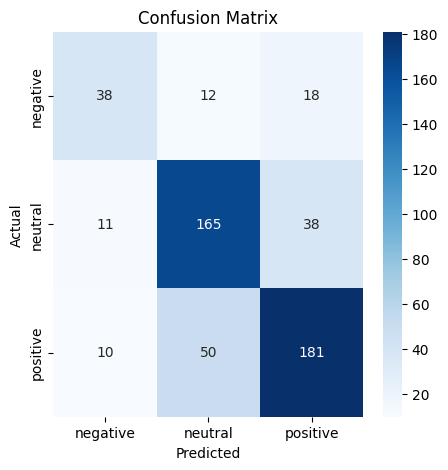

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

predicted_classes = label_encoder.inverse_transform(y_pred)
true_classes = label_encoder.inverse_transform(y_true)

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import classification_report

target_names = label_encoder.classes_
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.64      0.56      0.60        68
     neutral       0.73      0.77      0.75       214
    positive       0.76      0.75      0.76       241

    accuracy                           0.73       523
   macro avg       0.71      0.69      0.70       523
weighted avg       0.73      0.73      0.73       523



In [ ]:
# print(md5)

In [ ]:
# print(classifier)